In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import re 
import string

nltk.download('stopwords') # removes common words
nltk.download('wordnet') # used to convert word into its original form
nltk.download('punkt') # tokenization; splitting words in sentences

data = pd.read_csv(r"C:\Users\KIIT\Desktop\mini project\fake reviews dataset.csv")
print(data.shape)
data.head()

data['label'].value_counts()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(40432, 4)


label
CG    20216
OR    20216
Name: count, dtype: int64

In [3]:
#preprocessing functions
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

data['tokens'] = data['text_'].apply(lambda x: x.split())
data['tokens_no_stopwords'] = data['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

data['tokens_stemmed'] = data['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

data['cleaned_text'] = data['tokens_stemmed'].apply(lambda x: ' '.join(x))

data.head()


,category,rating,label,text_,tokens,tokens_no_stopwords,tokens_stemmed,cleaned_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...","[Love, this!, Well, made,, sturdy,, and, very,...","[Love, this!, Well, made,, sturdy,, comfortabl...","[love, this!, well, made,, sturdy,, comfortabl...","love this! well made, sturdy, comfortable. lov..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...","[love, it,, a, great, upgrade, from, the, orig...","[love, it,, great, upgrade, original., mine, c...","[love, it,, great, upgrad, original., mine, co...","love it, great upgrad original. mine coupl year"
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,"[This, pillow, saved, my, back., I, love, the,...","[pillow, saved, back., love, look, feel, pillow.]","[pillow, save, back., love, look, feel, pillow.]",pillow save back. love look feel pillow.
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...","[Missing, information, on, how, to, use, it,, ...","[Missing, information, use, it,, great, produc...","[miss, inform, use, it,, great, product, price!]","miss inform use it, great product price!"
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,"[Very, nice, set., Good, quality., We, have, h...","[nice, set., Good, quality., set, two, months]","[nice, set., good, quality., set, two, month]",nice set. good quality. set two month


In [4]:
# Initialize the SentimentIntensityAnalyzer (VADER)

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)['compound']
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['cleaned_text'].apply(get_sentiment)

# Count the number of occurrences of each sentiment type
sentiment_counts = data['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']



C:\Users\KIIT\AppData\Local\Temp\ipykernel_16568\4126897852.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette='viridis')


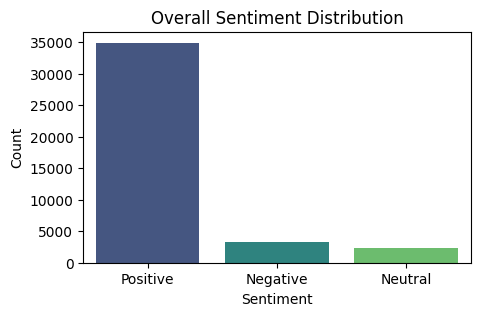

In [5]:
# Create a bar plot for overall sentiment distribution
plt.figure(figsize=(5, 3))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts, palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


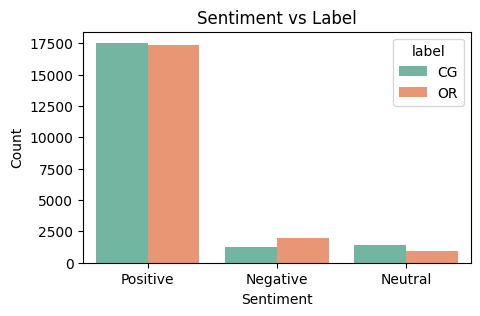

In [6]:
# If 'label' column contains categories, you can group by it
plt.figure(figsize=(5,3))
sns.countplot(x='sentiment', hue='label', data=data, palette='Set2')
plt.title('Sentiment vs Label')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X = data['cleaned_text']  # Feature (text data)
y = data['label']  # Target (label data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(X_test.shape)

(32345,)
(8087,)


In [8]:
vector = TfidfVectorizer(stop_words='english')

X_train_vector = vector.fit_transform(X_train)
X_test_vector = vector.transform(X_test)

In [9]:
model = SGDClassifier(max_iter=45000, penalty='l2', alpha=0.0001)
# cross validataion splits the data set in k parts and then finds the mean accuracy for the whole

cv_scores = cross_val_score(model, X_train_vector, y_train, cv=10, scoring='accuracy') 
print(f"Cross-validation scores for each fold: {cv_scores}")

mean_accuracy = cv_scores.mean()
print(f"Mean accuracy across all folds: {mean_accuracy * 100:.2f}%")
std_accuracy = cv_scores.std()
print(f"Standard deviation of accuracy across folds: {std_accuracy * 100:.2f}%")

model.fit(X_train_vector, y_train)
y_pred = model.predict(X_test_vector)
print(classification_report(y_test, y_pred))

#Logistic regression : 79.21  
#Multinomial naive bayes : 76.9
#Stochastic gradient descent : 79.42
#RandomForestClassifier : 71.97 (after 2m 16.8s)
#Bernouli Naive Bayes : 75.46
#after sentiment analysis, SDG = 85.74

#after using regularisation, no difference was found, l2 was close to the initial accuracy but not greater than it. 
#using grid search cv also did not help, it chose l2 @45k, alpha = 0.0001



Cross-validation scores for each fold: [0.85780526 0.85378671 0.8633694  0.85347759 0.85873261 0.86085343
 0.86209029 0.860235   0.85003092 0.85157699]
Mean accuracy across all folds: 85.72%
Standard deviation of accuracy across folds: 0.44%
              precision    recall  f1-score   support

          CG       0.88      0.82      0.85      4016
          OR       0.84      0.89      0.86      4071

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087



Confusion Matrix:
[[3311  705]
 [ 465 3606]]


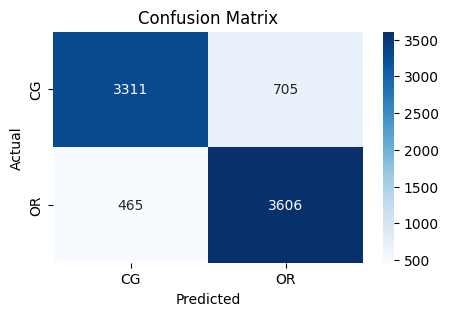

In [10]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_pred))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [14]:
def preprocess_input(input_text):
    tokens = input_text.split()
    tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
    tokens_stemmed = [stemmer.stem(word) for word in tokens_no_stopwords]
    cleaned_text = ' '.join(tokens_stemmed)
    
    return cleaned_text


def predict_sentiment(input_text):
    cleaned_input = preprocess_input(input_text)
    input_vector = vector.transform([cleaned_input])  # Transform it to the vector space used during training
    prediction = model.predict(input_vector)
    return prediction[0]  # return the predicted class (0 or 1)

# Define your input string
input_string = "Good"

# Get the prediction result
prediction = predict_sentiment(input_string)

# Print the result (if '1' means fake and '0' means real, for instance)
print(f"Prediction: {prediction}")


Prediction: CG
